In [2]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
from datetime import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

In [3]:
sales=pd.read_csv("./Data/sales_train.csv")
item_cat=pd.read_csv("./Data/item_categories.csv")
item=pd.read_csv("./Data/items.csv")
sub=pd.read_csv("./Data/sample_submission.csv")
shops=pd.read_csv("./Data/shops.csv")
test=pd.read_csv("./Data/test.csv")

In [4]:
#sales date_block_num by month
sales['date'] = sales['date'].apply(lambda x:datetime.strptime(x, '%d.%m.%Y'))

# Data Exploration

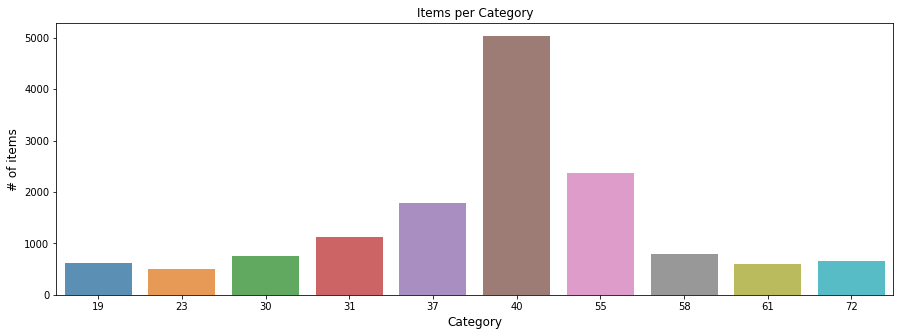

In [5]:
#top 10 item groups and count of products
itemgrps = item.groupby('item_category_id').count()
itemgrps = itemgrps.sort_values('item_id', ascending = False).iloc[0:10].reset_index()
itemgrps
plt.figure(figsize=(15,5))
ax = sns.barplot(itemgrps['item_category_id'],itemgrps['item_id'], alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [6]:
monthly_sales = sales.groupby(['date_block_num','shop_id','item_id'])[['date','item_price','item_cnt_day']].agg({'date':['min','max'],'item_price':'mean','item_cnt_day':'sum'})
monthly_sales

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
...                                   ...        ...        ...          ...
33             59      22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

[1609124 rows x 4 columns]

In [7]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


# Single Series Analysis

date_block_num
0    131479.0
1    128090.0
2    147142.0
3    107190.0
4    106970.0
Name: item_cnt_day, dtype: float64


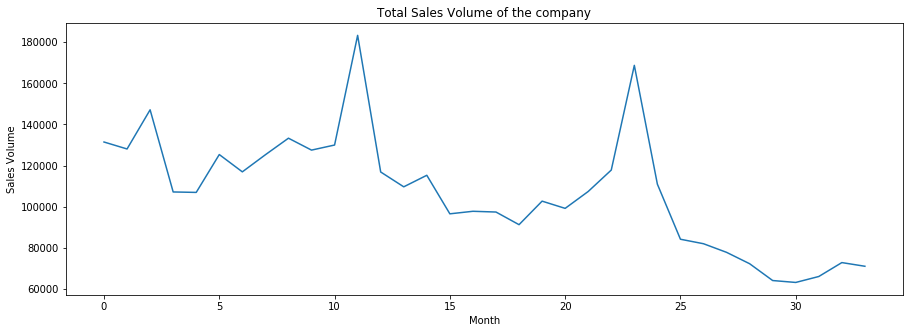

In [8]:
#clear seasonality, probably christmas sales
totalvol = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
totalvol.astype('float')
print(totalvol.head())
plt.figure(figsize=(15,5))
plt.title('Total Sales Volume of the company')
plt.xlabel('Month')
plt.ylabel('Sales Volume')
plt.plot(totalvol);

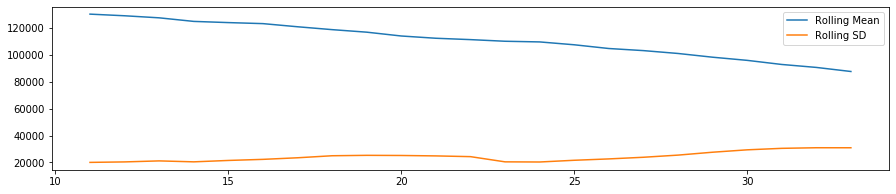

In [9]:
#this shows the general downward trend over the course of the year
plt.figure(figsize=(15,3))
plt.plot(totalvol.rolling(window=12, center=False).mean(), label='Rolling Mean');
plt.plot(totalvol.rolling(window=12, center=False).std(), label='Rolling SD');
plt.legend();

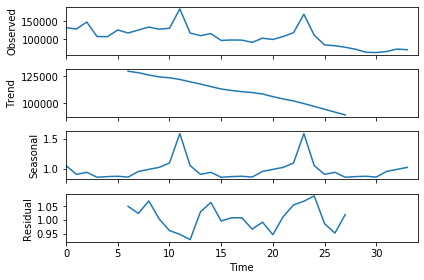

In [10]:
#run decomposition for trend, seasonality, and residuals
res = sm.tsa.seasonal_decompose(totalvol.values,freq=12,model='multiplicative')
fig = res.plot()

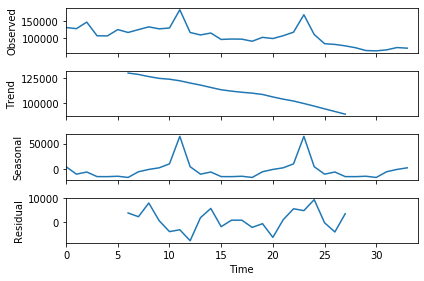

In [11]:
res = sm.tsa.seasonal_decompose(totalvol.values,freq=12,model="additive")
fig = res.plot()

In [13]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [14]:
#the test statistic is greater than the critical values. 
#p-value is also greater than signifance level of 0..05, so the time series is not stationary
test_stationarity(totalvol)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [15]:
#Create a differenced series to remove trend and seasonality
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

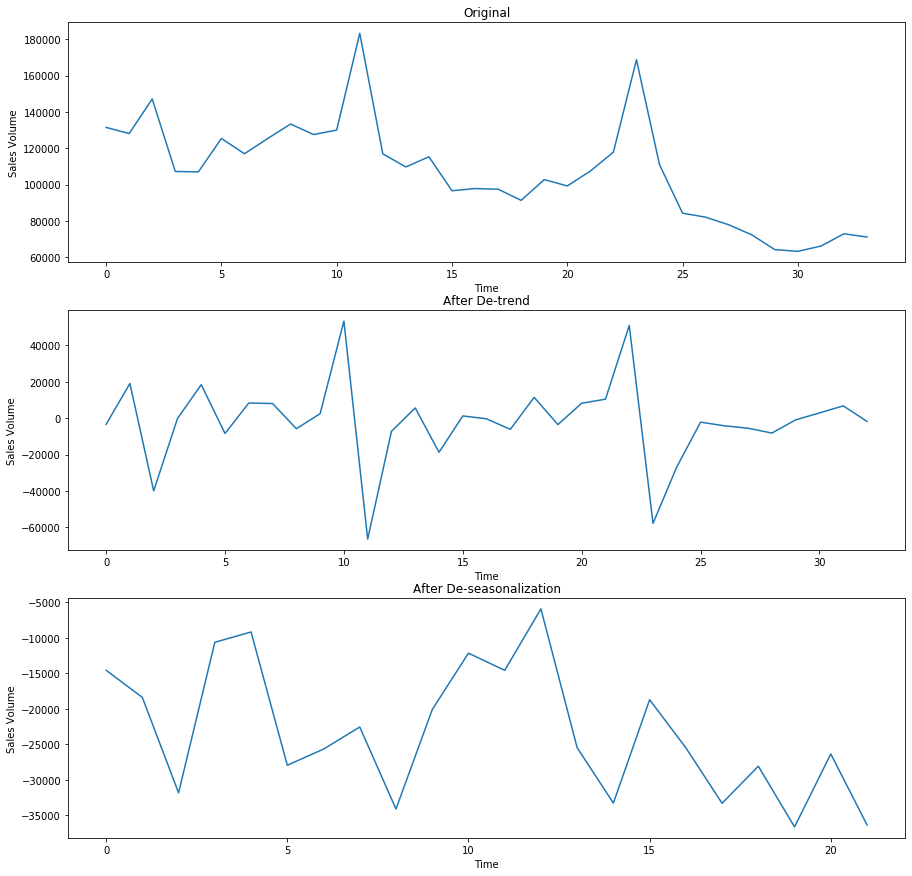

In [19]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales Volume')
plt.plot(ts);

# removing trend with interval of 1
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales Volume')
new_ts=difference(ts)
plt.plot(new_ts);

# assuming the seasonality is 12 months long
plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales Volume')
new_ts=difference(ts,12)       
plt.plot(new_ts);

In [20]:
#dataset stationary after removing seasonality
#pvalue less than 0.05 and test statistic less than critical values 5 and 10%
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64
